In [1]:
from pathlib import Path
import zipfile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays

import xgboost as xgb
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


In [2]:
# File path for reading the data from the zip file
zip_file_path = Path("..") /"data"/"external"/"AEP_hourly.csv.zip"

with zipfile.ZipFile(zip_file_path, 'r') as z:
    print(f"Files in the zip archive: {z.namelist()}")
    
    z.extractall(path=Path("..") /"data"/"raw")
    print("Extraction complete.")
    
    
    

Files in the zip archive: ['AEP_hourly.csv']
Extraction complete.


In [3]:
df = pd.read_csv(Path("..") /"data"/"raw"/"AEP_hourly.csv")
df_copy = df.copy()
df_copy.set_index('Datetime', inplace=True)
df_copy.index = pd.to_datetime(df_copy.index)

In [4]:

df_copy.head()


,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


In [5]:
df_copy.index

DatetimeIndex(['2004-12-31 01:00:00', '2004-12-31 02:00:00',
               '2004-12-31 03:00:00', '2004-12-31 04:00:00',
               '2004-12-31 05:00:00', '2004-12-31 06:00:00',
               '2004-12-31 07:00:00', '2004-12-31 08:00:00',
               '2004-12-31 09:00:00', '2004-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=121273, freq=None)

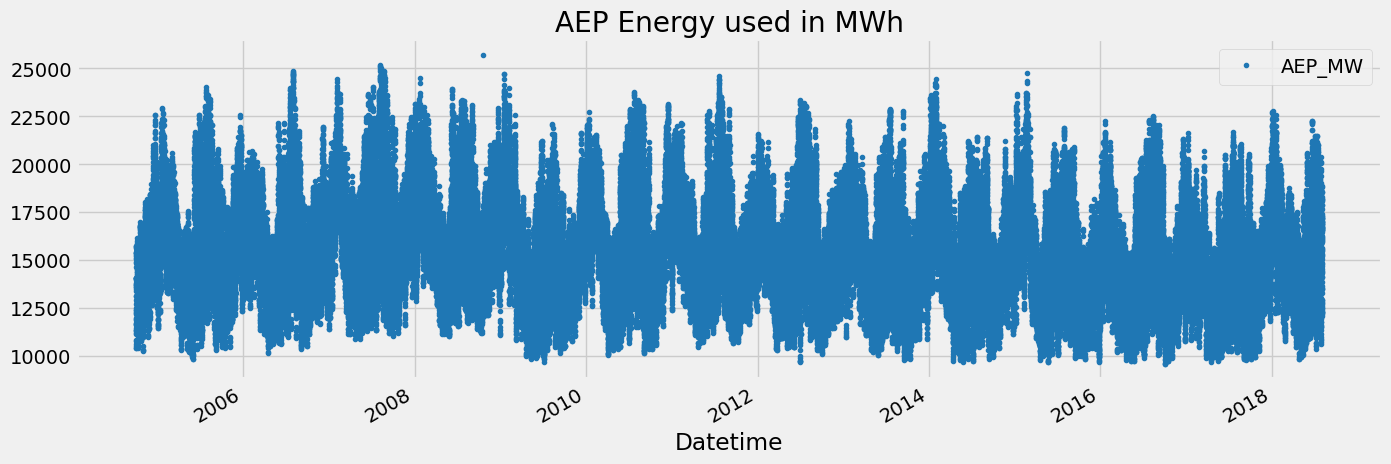

In [6]:
df_copy.plot(
    style='.', 
    figsize=(15, 5),
    color=color_pal[0],
    title='AEP Energy used in MWh'
    )
plt.show()

In [7]:
len(df_copy)

121273

## Train / Test Split

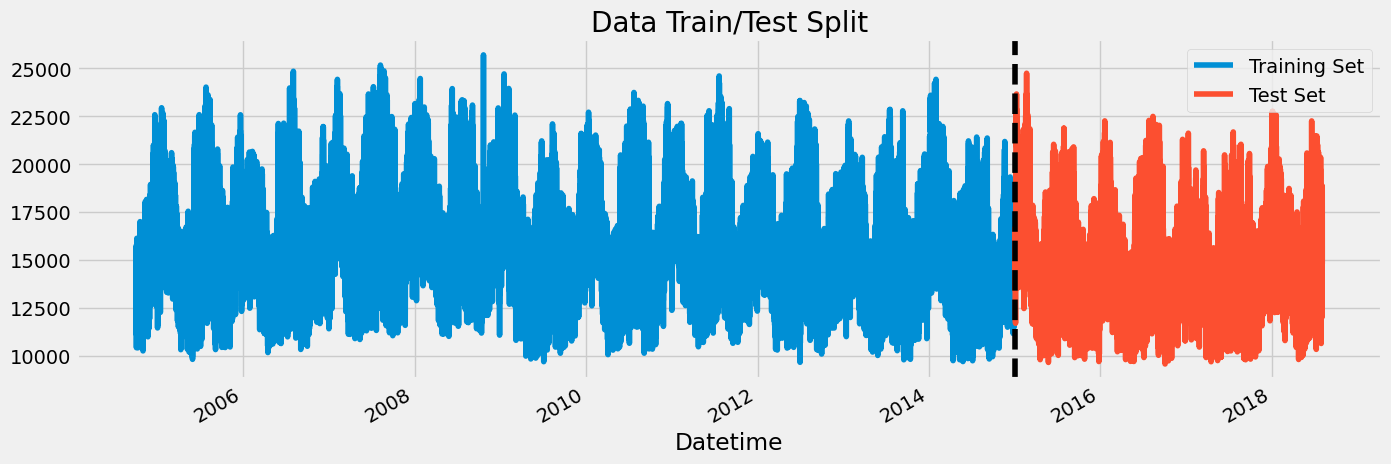

In [8]:
training_df = df_copy.loc[df_copy.index < '2015-01-01']
test_df = df_copy.loc[df_copy.index >= '2015-01-01']

fig, ax = plt.subplots(figsize=(15, 5))
training_df.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test_df.plot(ax=ax, label='Test Set')
ax.axvline(
    x=pd.to_datetime('2015-01-01'),
    color='black',
    linestyle='--'
)
ax.legend(['Training Set', 'Test Set'])
plt.show()

<Axes: title={'center': 'First week of January 2010'}, xlabel='Datetime'>

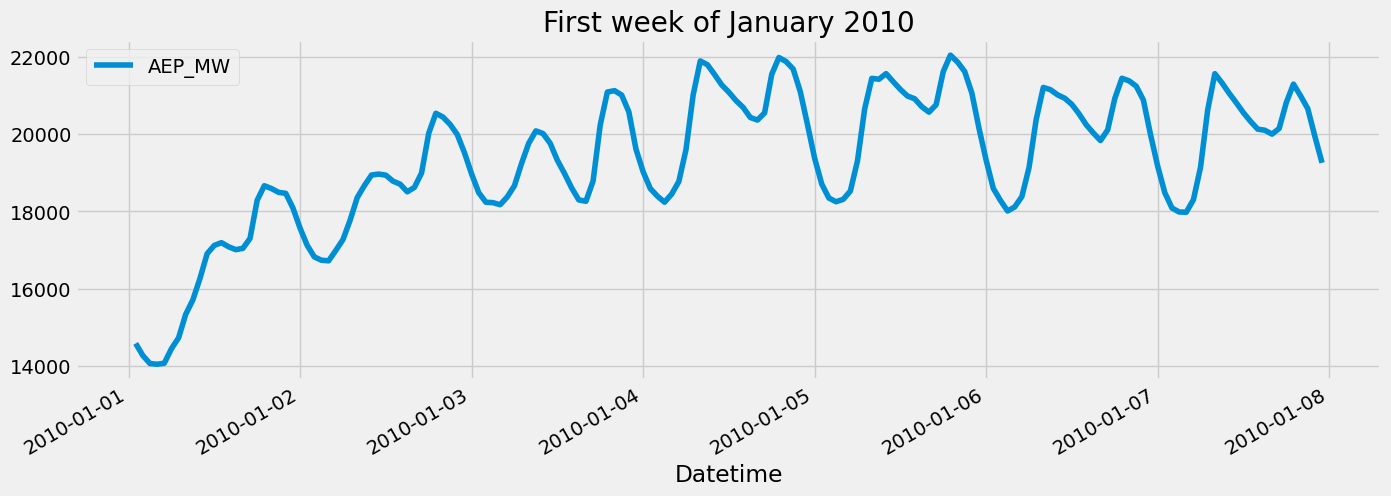

In [9]:
df_copy.loc[(df_copy.index > '2010-01-01') & (df_copy.index < '2010-01-08')].plot(
    figsize=(15, 5),
    title='First week of January 2010'
    )

## Feature Creation 

In [10]:
# def create_feature(df):
#     """
#     Create time series features based on datetime index including holiday flags and lags.
    
#     Parameters:
#         df (pd.DataFrame): DataFrame with a datetime index and target column 'AEP_MW'.
    
#     Returns:
#         pd.DataFrame: DataFrame with new features and dropped NA rows from lag/rolling calculations.
#     """
#     df_copy = df.copy()
    
#     # Basic time features
#     df_copy['hour'] = df_copy.index.hour
#     df_copy['day'] = df_copy.index.day
#     df_copy['dayofweek'] = df_copy.index.dayofweek
#     df_copy['month'] = df_copy.index.month
#     df_copy['quarter'] = df_copy.index.quarter
#     df_copy['year'] = df_copy.index.year
#     df_copy['dayofyear'] = df_copy.index.dayofyear
    
#     # Weekend flag
#     df_copy['is_weekend'] = df_copy['dayofweek'].isin([5, 6]).astype(int)
    
#     # Holiday flag (US holidays example)
#     us_holidays = holidays.US(years=df_copy.index.year.unique())
#     df_copy['is_holiday'] = df_copy.index.normalize().isin(us_holidays).astype(int)
    
#     # Specific holiday: New Year's Eve
#     df_copy['is_new_year_eve'] = ((df_copy['month'] == 12) & (df_copy['day'] == 31)).astype(int)
    
#     # Lag features
#     # df_copy['lag_1'] = df_copy['AEP_MW'].shift(1)
#     df_copy['lag_24'] = df_copy['AEP_MW'].shift(24)
#     df_copy['lag_168'] = df_copy['AEP_MW'].shift(168)  # Weekly lag
    
#     # Rolling statistics (rolling window = 24 hours)
#     df_copy['rolling_mean_24'] = df_copy['AEP_MW'].shift(1).rolling(window=24).mean()
#     df_copy['rolling_std_24'] = df_copy['AEP_MW'].shift(1).rolling(window=24).std()
    
#     # Cyclical encoding for hour, month, and dayofweek
#     df_copy['hour_sin'] = np.sin(2 * np.pi * df_copy['hour'] / 24)
#     df_copy['hour_cos'] = np.cos(2 * np.pi * df_copy['hour'] / 24)
    
#     df_copy['month_sin'] = np.sin(2 * np.pi * df_copy['month'] / 12)
#     df_copy['month_cos'] = np.cos(2 * np.pi * df_copy['month'] / 12)
    
#     df_copy['dayofweek_sin'] = np.sin(2 * np.pi * df_copy['dayofweek'] / 7)
#     df_copy['dayofweek_cos'] = np.cos(2 * np.pi * df_copy['dayofweek'] / 7)
    
#     # Interaction features
#     df_copy['hour_is_holiday'] = df_copy['hour'] * df_copy['is_holiday']
#     df_copy['hour_is_weekend'] = df_copy['hour'] * df_copy['is_weekend']
    
#     # Drop rows with NaN values created by shifts and rolling operations
#     df_copy = df_copy.dropna()
    
#     return df_copy


In [11]:
# def create_feature(df):
#     """
#     Create time series features for energy demand forecasting.
    
#     Parameters:
#         df (pd.DataFrame): Must contain a datetime index and column 'AEP_MW'.
    
#     Returns:
#         pd.DataFrame: DataFrame with features.
#     """
#     df_copy = df.copy()
#     df_copy.rename(columns={'AEP_MW': 'aep_mw'}, inplace=True)
    
#     # Basic time features
#     df_copy['hour'] = df_copy.index.hour
#     df_copy['day'] = df_copy.index.day
#     df_copy['dayofweek'] = df_copy.index.dayofweek
#     df_copy['month'] = df_copy.index.month
#     df_copy['quarter'] = df_copy.index.quarter
#     df_copy['year'] = df_copy.index.year
#     df_copy['dayofyear'] = df_copy.index.dayofyear

#     # Weekend & holiday
#     df_copy['is_weekend'] = df_copy['dayofweek'].isin([5, 6]).astype(int)
#     us_holidays = holidays.US(years=df_copy.index.year.unique())
#     df_copy['is_holiday'] = df_copy.index.normalize().isin(us_holidays).astype(int)
#     df_copy['is_new_year_eve'] = ((df_copy['month'] == 12) & (df_copy['day'] == 31)).astype(int)

#     # Lag features
#     df_copy['lag_24'] = df_copy['aep_mw'].shift(24)
#     df_copy['lag_48'] = df_copy['aep_mw'].shift(48)
#     df_copy['lag_72'] = df_copy['aep_mw'].shift(72)
#     df_copy['lag_168'] = df_copy['aep_mw'].shift(168)
   
#     # Rolling stats (with shift to prevent leakage)
#     df_copy['rolling_mean_24'] = df_copy['aep_mw'].shift(1).rolling(window=24).mean()
#     df_copy['rolling_std_24'] = df_copy['aep_mw'].shift(1).rolling(window=24).std()

#     # Cyclical encoding
#     df_copy['hour_sin'] = np.sin(2 * np.pi * df_copy['hour'] / 24)
#     df_copy['hour_cos'] = np.cos(2 * np.pi * df_copy['hour'] / 24)
#     df_copy['month_sin'] = np.sin(2 * np.pi * df_copy['month'] / 12)
#     df_copy['month_cos'] = np.cos(2 * np.pi * df_copy['month'] / 12)
#     df_copy['dayofweek_sin'] = np.sin(2 * np.pi * df_copy['dayofweek'] / 7)
#     df_copy['dayofweek_cos'] = np.cos(2 * np.pi * df_copy['dayofweek'] / 7)

#     # Interaction features
#     df_copy['hour_is_holiday'] = df_copy['hour'] * df_copy['is_holiday']
#     df_copy['hour_is_weekend'] = df_copy['hour'] * df_copy['is_weekend']

#     # Outlier flag (based on IQR of aep_mw)
#     Q1 = df_copy['aep_mw'].quantile(0.25)
#     Q3 = df_copy['aep_mw'].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     df_copy['is_outlier'] = ((df_copy['aep_mw'] < lower_bound) | (df_copy['aep_mw'] > upper_bound)).astype(int)

#     # Drop NA rows created by lags/rolling
#     df_copy.dropna(inplace=True)

#     return df_copy


In [12]:
def create_features(df):
    """
    Create cleaned and optimized time series features for energy demand forecasting.

    Parameters:
        df (pd.DataFrame): Must contain a datetime index and column 'AEP_MW'.

    Returns:
        pd.DataFrame: DataFrame with feature-engineered columns.
    """
    df_copy = df.copy()
    df_copy.columns = df_copy.columns.str.lower()

    # ─── Basic time features ─────────────────────────────────────────────
    df_copy['hour'] = df_copy.index.hour
    df_copy['dayofweek'] = df_copy.index.dayofweek
    df_copy['month'] = df_copy.index.month

    # ─── Weekend & Holiday flags ─────────────────────────────────────────
    df_copy['is_weekend'] = df_copy['dayofweek'].isin([5, 6]).astype(int)
    us_holidays = holidays.US(years=df_copy.index.year.unique())
    df_copy['is_holiday'] = df_copy.index.normalize().isin(us_holidays).astype(int)
    df_copy['is_new_year_eve'] = ((df_copy['month'] == 12) & (df_copy.index.day == 31)).astype(int)

    # ─── Lag features ────────────────────────────────────────────────────
    df_copy['lag_24'] = df_copy['aep_mw'].shift(24)
    # df_copy['lag_168'] = df_copy['aep_mw'].shift(168)

    # ─── Rolling statistics ──────────────────────────────────────────────
    df_copy['rolling_mean_24'] = df_copy['aep_mw'].shift(1).rolling(window=24).mean()
    df_copy['rolling_std_24'] = df_copy['aep_mw'].shift(1).rolling(window=24).std()

    # ─── Cyclical encoding ───────────────────────────────────────────────
    df_copy['hour_sin'] = np.sin(2 * np.pi * df_copy['hour'] / 24)
    df_copy['hour_cos'] = np.cos(2 * np.pi * df_copy['hour'] / 24)
    df_copy['month_cos'] = np.cos(2 * np.pi * df_copy['month'] / 12)
    df_copy['dayofweek_cos'] = np.cos(2 * np.pi * df_copy['dayofweek'] / 7)

    # ─── Interaction features ────────────────────────────────────────────
    df_copy['hour_is_holiday'] = df_copy['hour'] * df_copy['is_holiday']
    df_copy['hour_is_weekend'] = df_copy['hour'] * df_copy['is_weekend']

    # ─── Time of Day flags ───────────────────────────────────────────────
    hour = df_copy['hour']
    df_copy['is_night'] = hour.isin(range(0, 6)).astype(int)
    df_copy['is_morning'] = hour.isin(range(6, 12)).astype(int)
    df_copy['is_noon'] = hour.isin(range(12, 18)).astype(int)
    df_copy['is_evening'] = hour.isin(range(18, 24)).astype(int)

    # ─── Outlier flag (based on IQR of aep_mw) ───────────────────────────
    Q1 = df_copy['aep_mw'].quantile(0.25)
    Q3 = df_copy['aep_mw'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_copy['is_outlier'] = ((df_copy['aep_mw'] < lower_bound) | (df_copy['aep_mw'] > upper_bound)).astype(int)

    # ─── Drop NA rows from lags and rolling stats ────────────────────────
    df_copy.dropna(inplace=True)

    return df_copy


In [13]:
df_features = create_features(df_copy)
df_features.columns

Index(['aep_mw', 'hour', 'dayofweek', 'month', 'is_weekend', 'is_holiday',
       'is_new_year_eve', 'lag_24', 'rolling_mean_24', 'rolling_std_24',
       'hour_sin', 'hour_cos', 'month_cos', 'dayofweek_cos', 'hour_is_holiday',
       'hour_is_weekend', 'is_night', 'is_morning', 'is_noon', 'is_evening',
       'is_outlier'],
      dtype='object')

In [14]:
# df_features.columns = df_features.columns.str.lower()

In [15]:
df_features.columns

Index(['aep_mw', 'hour', 'dayofweek', 'month', 'is_weekend', 'is_holiday',
       'is_new_year_eve', 'lag_24', 'rolling_mean_24', 'rolling_std_24',
       'hour_sin', 'hour_cos', 'month_cos', 'dayofweek_cos', 'hour_is_holiday',
       'hour_is_weekend', 'is_night', 'is_morning', 'is_noon', 'is_evening',
       'is_outlier'],
      dtype='object')

In [16]:
df_features.shape

(121249, 21)

In [17]:
df_features.describe()

,aep_mw,hour,dayofweek,month,is_weekend,is_holiday,is_new_year_eve,lag_24,rolling_mean_24,rolling_std_24,...,hour_cos,month_cos,dayofweek_cos,hour_is_holiday,hour_is_weekend,is_night,is_morning,is_noon,is_evening,is_outlier
count,121249.000000,121249.000000,121249.000000,121249.000000,121249.000000,121249.000000,121249.000000,121249.000000,121249.000000,121249.000000,...,1.212490e+05,1.212490e+05,121249.000000,121249.000000,121249.000000,121249.000000,121249.000000,121249.000000,121249.000000,121249.000000
mean,15499.800881,11.501588,2.999307,6.499311,0.285652,0.030681,0.002581,15498.708418,15499.220775,1656.931888,...,-1.297299e-04,5.200155e-04,0.000080,0.352828,3.286543,0.249866,0.250047,0.250039,0.250047,0.005501
std,2591.545129,6.921830,1.999959,3.460931,0.451726,0.172452,0.050743,2590.996580,1899.663271,703.650054,...,7.070980e-01,7.115410e-01,0.707080,2.324476,6.379176,0.432937,0.433042,0.433037,0.433042,0.073965
min,9581.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,9581.000000,11072.666667,363.622054,...,-1.000000e+00,-1.000000e+00,-0.900969,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13630.000000,6.000000,1.000000,4.000000,0.000000,0.000000,0.000000,13630.000000,14094.958333,1147.458919,...,-7.071068e-01,-8.660254e-01,-0.900969,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15311.000000,12.000000,3.000000,6.000000,0.000000,0.000000,0.000000,15309.000000,15293.083333,1457.696035,...,-1.836970e-16,6.123234e-17,-0.222521,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,17201.000000,18.000000,5.000000,10.000000,1.000000,0.000000,0.000000,17200.000000,16773.125000,2061.334365,...,7.071068e-01,8.660254e-01,0.623490,0.000000,2.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,25695.000000,23.000000,6.000000,12.000000,1.000000,1.000000,1.000000,25695.000000,22849.875000,4820.058571,...,1.000000e+00,1.000000e+00,1.000000,23.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
# Analyze outliers using the IQR (Interquartile Range) method
Q1 = df_features['aep_mw'].quantile(0.25)
Q3 = df_features['aep_mw'].quantile(0.75)
IQR = Q3 - Q1

# Calculate lower and upper bounds for outliers
min_range = Q1 - 1.5 * IQR
max_range = Q3 + 1.5 * IQR

print(f"Q1: {Q1}")
print(f"Q3: {Q3}")
print(f"IQR: {IQR}")
print(f"Lower bound (min_range): {min_range}")
print(f"Upper bound (max_range): {max_range}")

# Detect outliers
outliers = df_features[(df_features['aep_mw'] < min_range) | (df_features['aep_mw'] > max_range)]
print(f"Outliers:\n{outliers}")


Q1: 13630.0
Q3: 17201.0
IQR: 3571.0
Lower bound (min_range): 8273.5
Upper bound (max_range): 22557.5
Outliers:
                      aep_mw  hour  dayofweek  month  is_weekend  is_holiday  \
Datetime                                                                       
2004-12-20 09:00:00  22577.0     9          0     12           0           0   
2005-12-20 08:00:00  22573.0     8          1     12           0           0   
2005-08-12 14:00:00  22909.0    14          4      8           0           0   
2005-08-12 15:00:00  23371.0    15          4      8           0           0   
2005-08-12 16:00:00  23243.0    16          4      8           0           0   
...                      ...   ...        ...    ...         ...         ...   
2018-01-18 08:00:00  22567.0     8          3      1           0           0   
2018-01-03 08:00:00  22759.0     8          2      1           0           0   
2018-01-03 09:00:00  22624.0     9          2      1           0           0   
2018-01-0

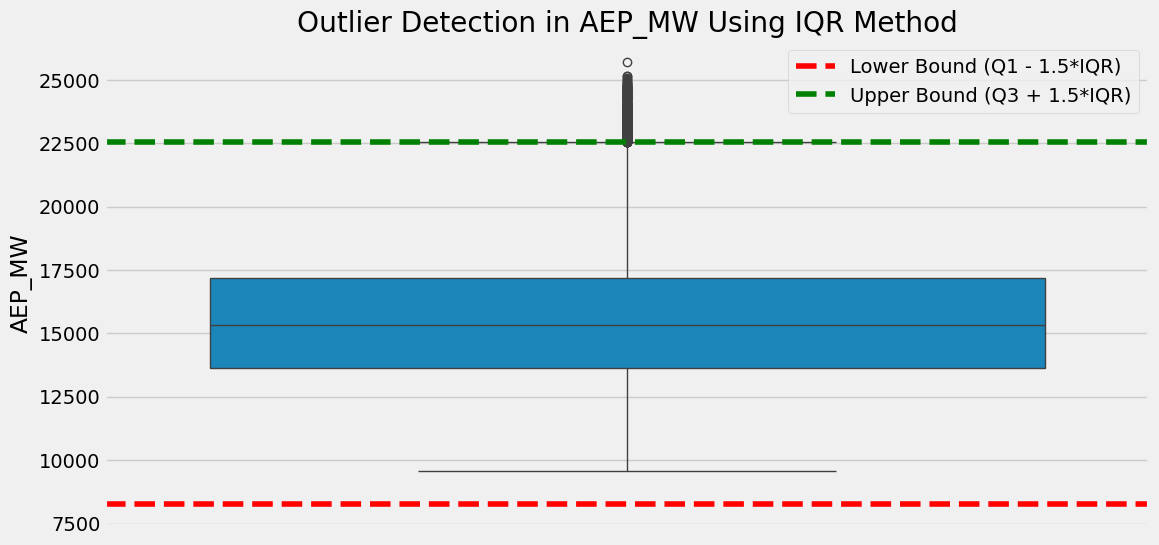

In [19]:
# Boxplot Visualization (with IQR bounds)

plt.figure(figsize=(12, 6))
sns.boxplot(y=df_features['aep_mw'])
plt.axhline(8270, color='red', linestyle='--', label='Lower Bound (Q1 - 1.5*IQR)')
plt.axhline(22558, color='green', linestyle='--', label='Upper Bound (Q3 + 1.5*IQR)')
plt.title('Outlier Detection in AEP_MW Using IQR Method')
plt.ylabel('AEP_MW')
plt.legend()
plt.show()

In [20]:
# outliers = df_features[
#     (df_features['aep_mw'] > max_range)
# ]
# print(f"Outliers:\n{outliers}")

df_features['is_outlier'] = ((df_features['aep_mw'] < 8270.0) | (df_features['aep_mw'] > 22558.0)).astype(int)


In [21]:
df_features[df_features['is_outlier'] == 1]

,aep_mw,hour,dayofweek,month,is_weekend,is_holiday,is_new_year_eve,lag_24,rolling_mean_24,rolling_std_24,...,hour_cos,month_cos,dayofweek_cos,hour_is_holiday,hour_is_weekend,is_night,is_morning,is_noon,is_evening,is_outlier
Datetime,,,,,,,,,,,,,,,,,,,,,
2004-12-20 09:00:00,22577.0,9,0,12,0,0,0,20218.0,18978.375000,1332.527504,...,-0.707107,1.000000,1.000000,0,0,0,1,0,0,1
2005-12-20 08:00:00,22573.0,8,1,12,0,0,0,21319.0,19858.041667,1065.078135,...,-0.500000,1.000000,0.623490,0,0,0,1,0,0,1
2005-08-12 14:00:00,22909.0,14,4,8,0,0,0,20991.0,18236.000000,2690.638101,...,-0.866025,-0.500000,-0.900969,0,0,0,0,1,0,1
2005-08-12 15:00:00,23371.0,15,4,8,0,0,0,21165.0,18315.916667,2802.195504,...,-0.707107,-0.500000,-0.900969,0,0,0,0,1,0,1
2005-08-12 16:00:00,23243.0,16,4,8,0,0,0,21391.0,18407.833333,2932.847817,...,-0.500000,-0.500000,-0.900969,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-18 08:00:00,22567.0,8,3,1,0,0,0,20925.0,18607.125000,1696.806676,...,-0.500000,0.866025,-0.900969,0,0,0,1,0,0,1
2018-01-03 08:00:00,22759.0,8,2,1,0,0,0,21308.0,21229.333333,663.160199,...,-0.500000,0.866025,-0.222521,0,0,0,1,0,0,1
2018-01-03 09:00:00,22624.0,9,2,1,0,0,0,21387.0,21289.791667,733.097655,...,-0.707107,0.866025,-0.222521,0,0,0,1,0,0,1


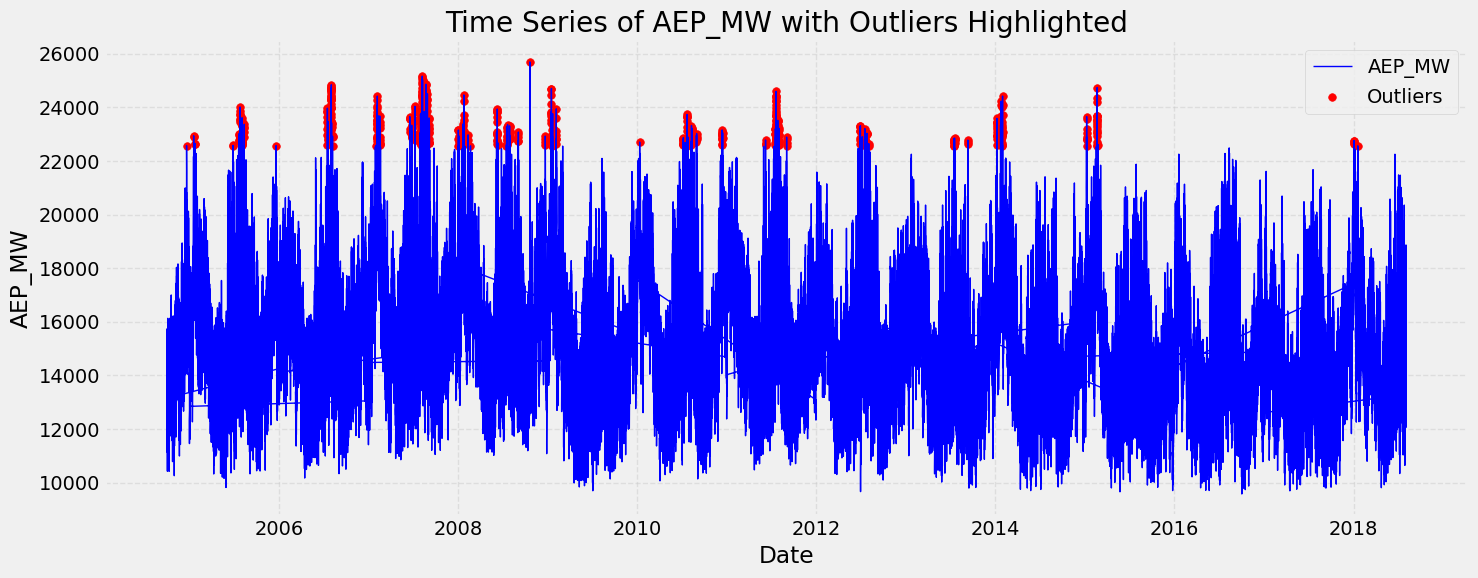

In [22]:
# And your outliers are stored in a DataFrame named `outliers`

plt.figure(figsize=(15, 6))

# Plot full series
plt.plot(df_features.index, df_features['aep_mw'], label='AEP_MW', color='blue', linewidth=1)

# Plot outliers in red
plt.scatter(outliers.index, outliers['aep_mw'], color='red', label='Outliers', s=30)

plt.title('Time Series of AEP_MW with Outliers Highlighted')
plt.xlabel('Date')
plt.ylabel('AEP_MW')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


## Visualize our Feature / Target Relationship

Text(0.5, 1.0, 'MW by Hour of Day')

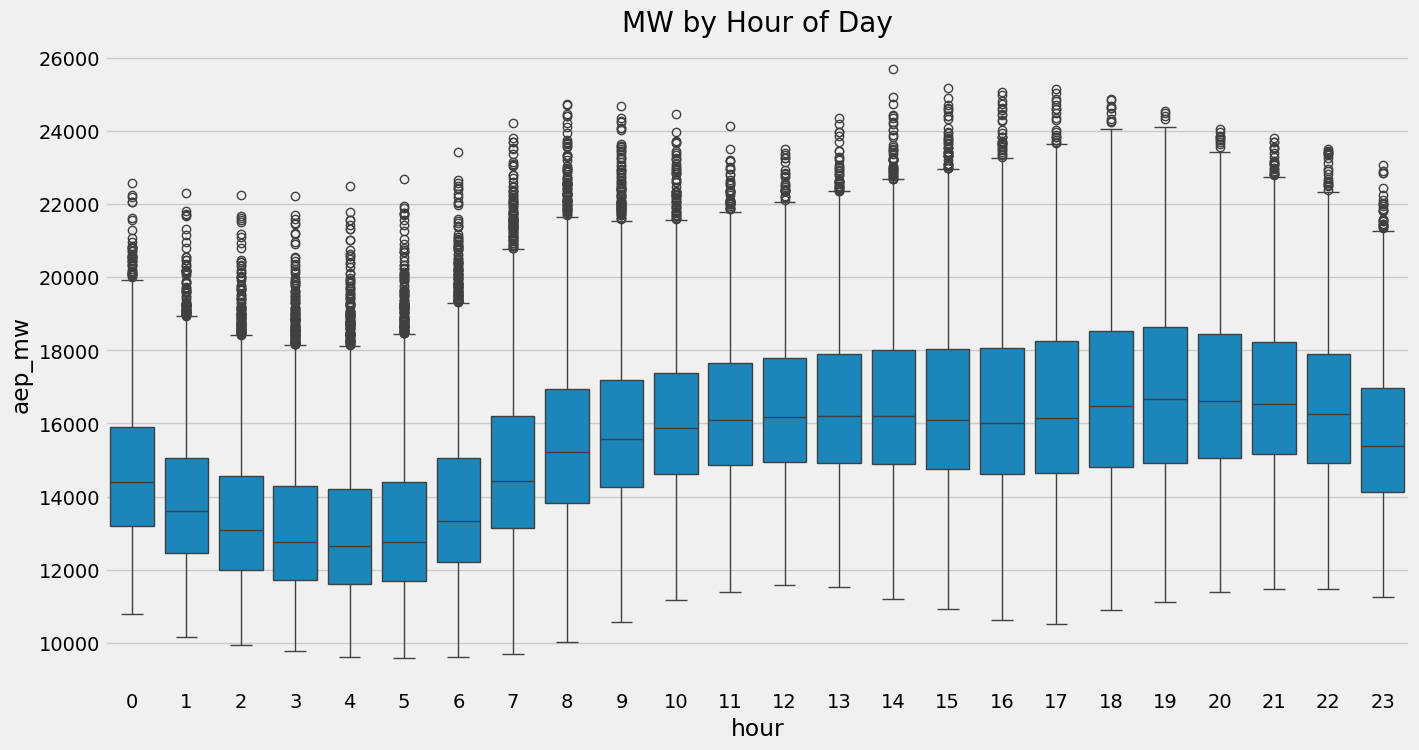

In [23]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(data=df_features, x='hour', y='aep_mw', ax=ax)
ax.set_title('MW by Hour of Day')

C:\Users\Juges Debnath\AppData\Local\Temp\ipykernel_7024\67379902.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_features, x='month', y='aep_mw', palette='Set3')


Text(0.5, 1.0, 'MW by Hour of Month')

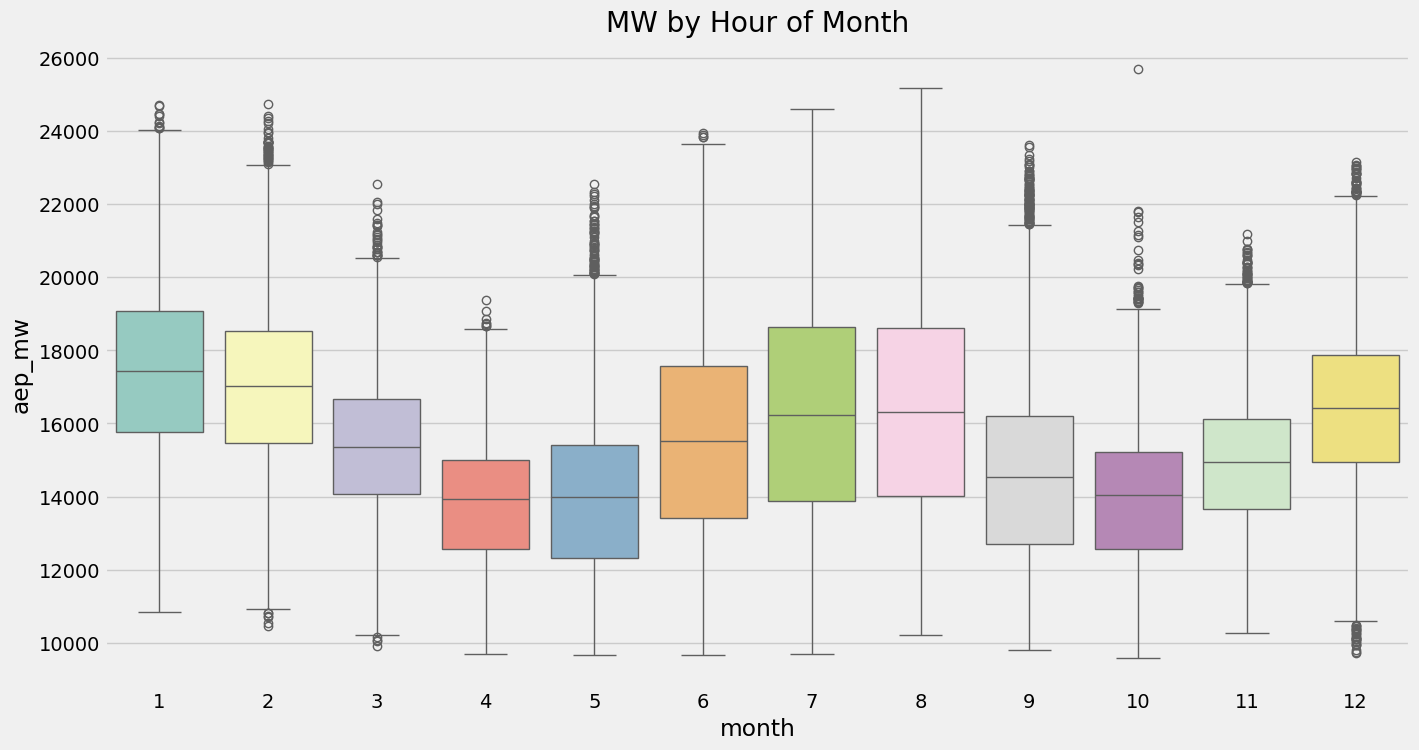

In [24]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(data=df_features, x='month', y='aep_mw', palette='Set3')
ax.set_title('MW by Hour of Month')

## Create our Model

In [25]:
train = create_features(training_df).dropna()
test = create_features(test_df).dropna()

In [26]:
# train.columns = train.columns.str.lower()
# test.columns = test.columns.str.lower()

In [27]:
feature_columns = [
    'hour',
    'dayofweek',
    'month',
    'is_weekend',
    'is_holiday',
    'is_new_year_eve',
    'lag_24',
    # 'lag_168',
    'rolling_mean_24',
    'rolling_std_24',
    'hour_sin',
    'hour_cos',
    'month_cos',
    'dayofweek_cos',
    'hour_is_holiday',
    'hour_is_weekend',
    'is_night',
    'is_morning',
    'is_noon',
    'is_evening',
    'is_outlier'
]

target = 'aep_mw'


In [28]:
x_train = train[feature_columns]
y_train = train[target]
x_test = test[feature_columns]
y_test = test[target]

In [29]:
print("Mean:", y_train.mean())
print("Std Dev:", y_train.std())

Mean: 15742.3957398479
Std Dev: 2573.5843632809856


In [30]:
# Uncomment and rerun this block ONLY if you change features or want to re-tune hyperparameters.

# Define the parameter grid
# param_grid = {
#     'max_depth':[5, 6, 7, 8, 9],
#     'reg_alpha':[0, 0.1, 1, 10],
#     'reg_lambda':[0, 0.1, 1, 10], 
#     'learning_rate':[0.001, 0.005, 0.1],
#     'n_estimators':[1000, 1500, 2000, 3000]
# }

In [31]:
# Uncomment and rerun this block ONLY if you change features or want to re-tune hyperparameters.

# # Create the XGBRegressor and training logs (verbosity = 0) during search
# xgb_reg = xgb.XGBRegressor(
#     early_stopping_rounds=100,
#     random_state=42,
#     verbosity=0
# )

# # Setup RandomizedSearchCV
# random_search = RandomizedSearchCV(
#     estimator=xgb_reg,
#     param_distributions=param_grid,
#     n_iter=70,
#     scoring='neg_root_mean_squared_error',
#     cv=3,
#     verbose=2,
#     random_state=42,
#     n_jobs=-1
# )

# random_search.fit(
#     x_train, 
#     y_train, 
#     eval_set=[(x_train, y_train), (x_test, y_test)],
#     verbose=False
#     )
   

In [32]:
# Best parameters and score
# print("Best Parameters:", random_search.best_params_)
# print("Best Score:", -random_search.best_score_)

In [33]:
# XGBoost model with best parameters
# xgb.XGBRegressor(objective='reg:squarederror')  # Default
# xgb.XGBRegressor(objective='reg:absoluteerror')  # L1 — more robust to outliers

xgb_best = xgb.XGBRegressor(
    objective='reg:absoluteerror',
    n_estimators=1500,
    learning_rate=0.1,
    max_depth=5,
    reg_alpha=1,
    reg_lambda=10,
    random_state=42
)

xgb_best.fit(
    x_train, 
    y_train,
    eval_set=[(x_train, y_train), (x_test, y_test)],
    verbose=False
)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1500, n_jobs=None,
             num_parallel_tree=None, objective='reg:absoluteerror', ...)

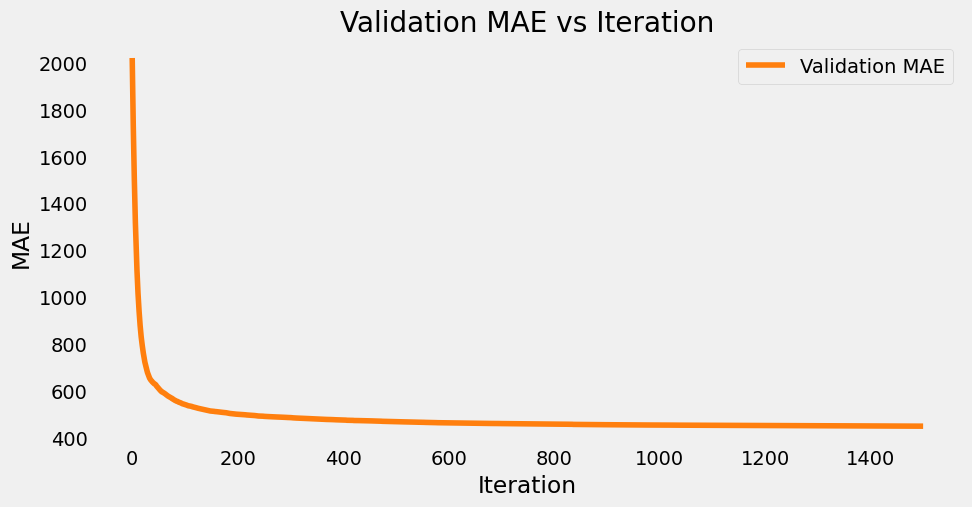

In [34]:
# Plot validation MAE vs iteration
evals_result = xgb_best.evals_result()
val_mae = evals_result['validation_1']['mae']
plt.figure(figsize=(10, 5))
plt.plot(val_mae, label='Validation MAE', color=color_pal[1])
plt.xlabel('Iteration')
plt.ylabel('MAE')
plt.title('Validation MAE vs Iteration')
plt.legend()
plt.grid()
plt.show()

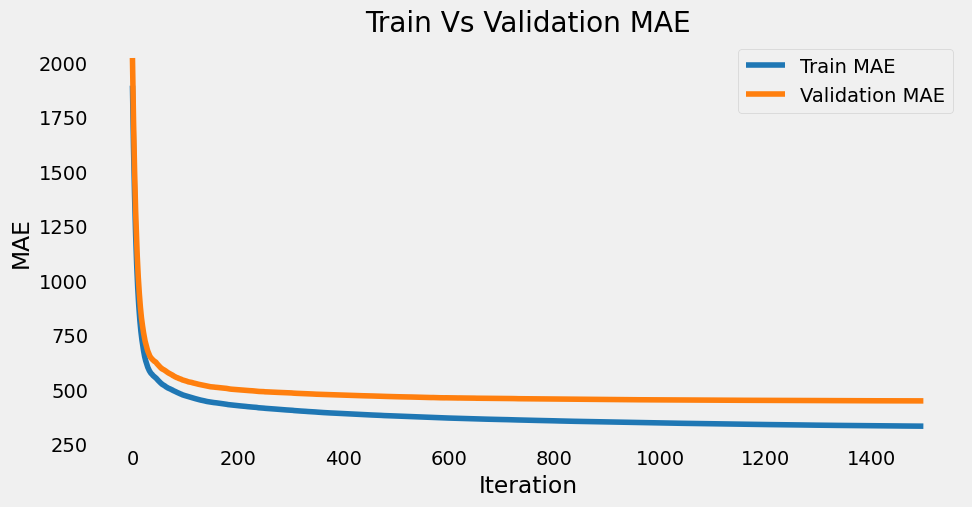

In [35]:
# Plot learning curves for both train and validation (optional, but useful):
train_mae = evals_result['validation_0']['mae']
val_mae = evals_result['validation_1']['mae']

plt.figure(figsize=(10, 5))
plt.plot(train_mae, label='Train MAE', color=color_pal[0])
plt.plot(val_mae, label='Validation MAE', color=color_pal[1])
plt.xlabel('Iteration')
plt.ylabel('MAE')
plt.title('Train Vs Validation MAE')
plt.legend()
plt.grid()
plt.show()

## Feature Importance

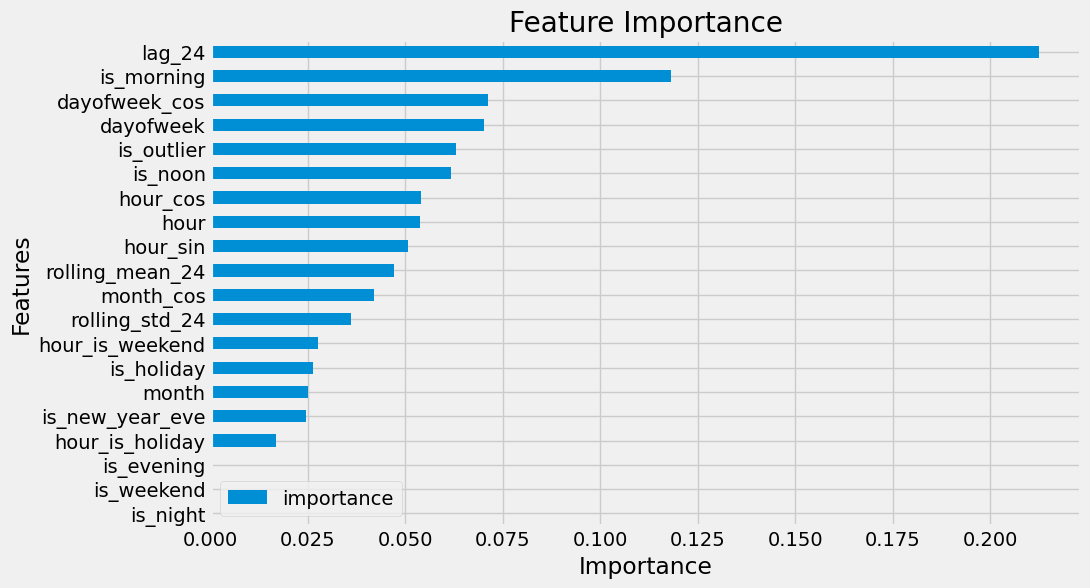

In [36]:
fi = pd.DataFrame(
    data = xgb_best.feature_importances_, 
    index = xgb_best.feature_names_in_,
    columns = ['importance']
)
fi.sort_values(by='importance', ascending=True).plot(
    kind='barh',
    title='Feature Importance',
    xlabel='Importance',
    ylabel='Features',
    figsize=(10, 6)
)
plt.show()

## Forecast on Test

In [37]:
test['prediction'] = xgb_best.predict(x_test)
df_copy = df_copy.merge(test[['prediction']], left_index=True, right_index=True)
df_copy.columns  = df_copy.columns.str.lower()

In [38]:
type(df_copy)

pandas.core.frame.DataFrame

In [39]:
df_copy.head(10)

,aep_mw,prediction
Datetime,,
2015-01-01 01:00:00,16172.0,15149.258789
2015-01-01 02:00:00,15968.0,15105.841797
2015-01-01 03:00:00,15749.0,15221.738281
2015-01-01 04:00:00,15727.0,15833.953125
2015-01-01 05:00:00,15710.0,15882.875977
2015-01-01 06:00:00,15937.0,16264.037109
2015-01-01 07:00:00,16239.0,16799.726562
2015-01-01 08:00:00,16573.0,16949.027344
2015-01-01 09:00:00,16600.0,17243.039062


In [ ]:
df_copy['ape%'] = df_copy.apply(lambda row: np.abs(row['aep_mw'] - row['prediction']) / row['aep_mw'] * 100 if row['aep_mw'] != 0 else 0, axis=1).round(2)  

In [41]:
df_copy.head(10)

,aep_mw,prediction,ape%
Datetime,,,
2015-01-01 01:00:00,16172.0,15149.258789,6.32
2015-01-01 02:00:00,15968.0,15105.841797,5.40
2015-01-01 03:00:00,15749.0,15221.738281,3.35
2015-01-01 04:00:00,15727.0,15833.953125,0.68
2015-01-01 05:00:00,15710.0,15882.875977,1.10
2015-01-01 06:00:00,15937.0,16264.037109,2.05
2015-01-01 07:00:00,16239.0,16799.726562,3.45
2015-01-01 08:00:00,16573.0,16949.027344,2.27
2015-01-01 09:00:00,16600.0,17243.039062,3.87


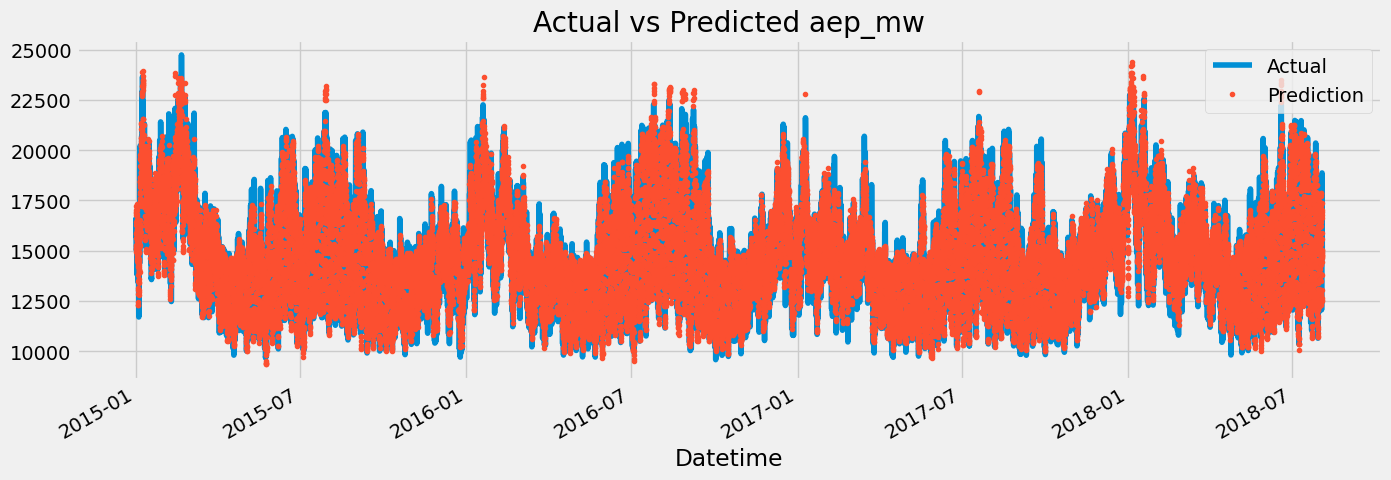

In [42]:
ax = df_copy[['aep_mw']].plot(figsize=(15, 5))
df_copy[['prediction']].plot(ax=ax, style='.')
plt.legend(['Actual', 'Prediction'])
ax.set_title('Actual vs Predicted aep_mw')
plt.show()

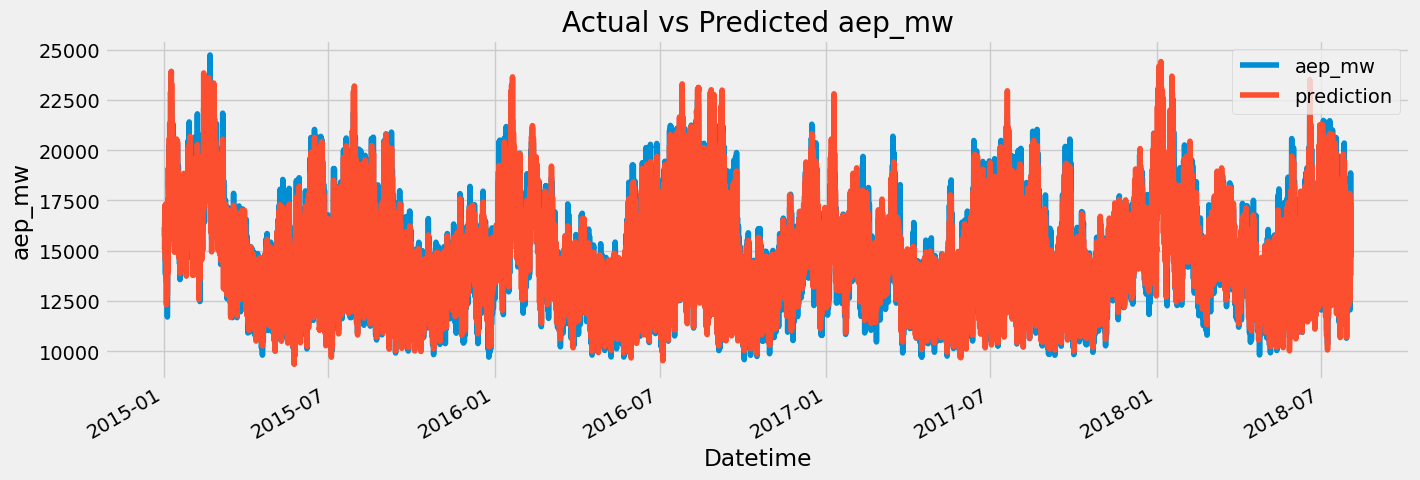

In [43]:
ax = df_copy[['aep_mw', 'prediction']].plot(
    figsize=(15, 5), 
    label=['Actual', 'Prediction'],
    title='Actual vs Predicted aep_mw',
    xlabel='Datetime',
    ylabel='aep_mw',
    grid=True
)
plt.show()

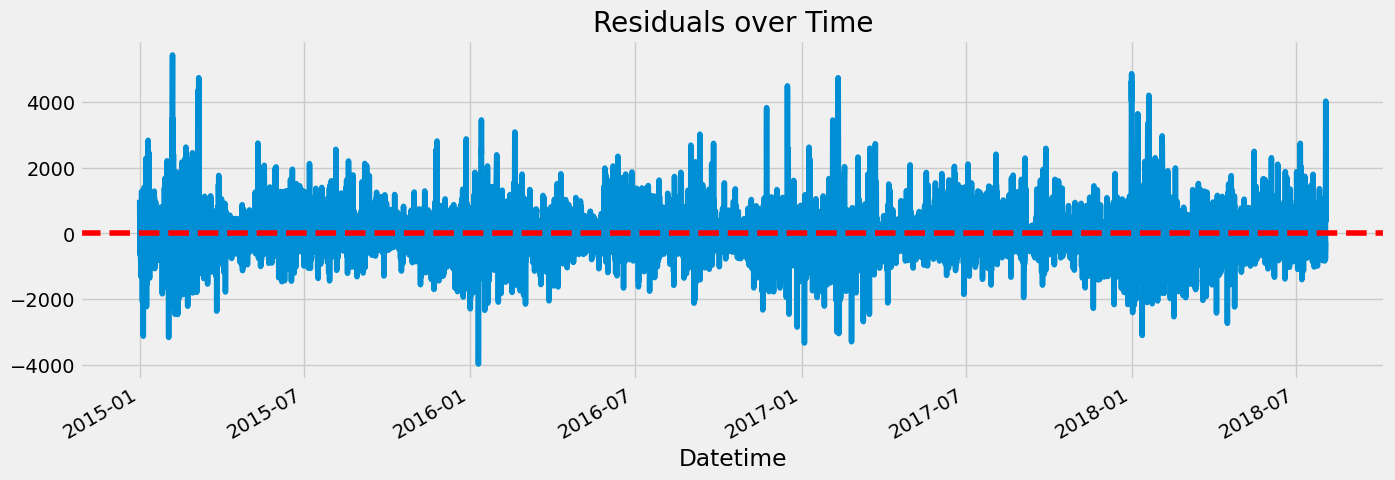

In [44]:
# Plot Residuals (Optional Diagnostic Tool)

df_copy['residuals'] = df_copy['aep_mw'] - df_copy['prediction']
df_copy['residuals'].plot(figsize=(15, 5))
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals over Time')
plt.show()


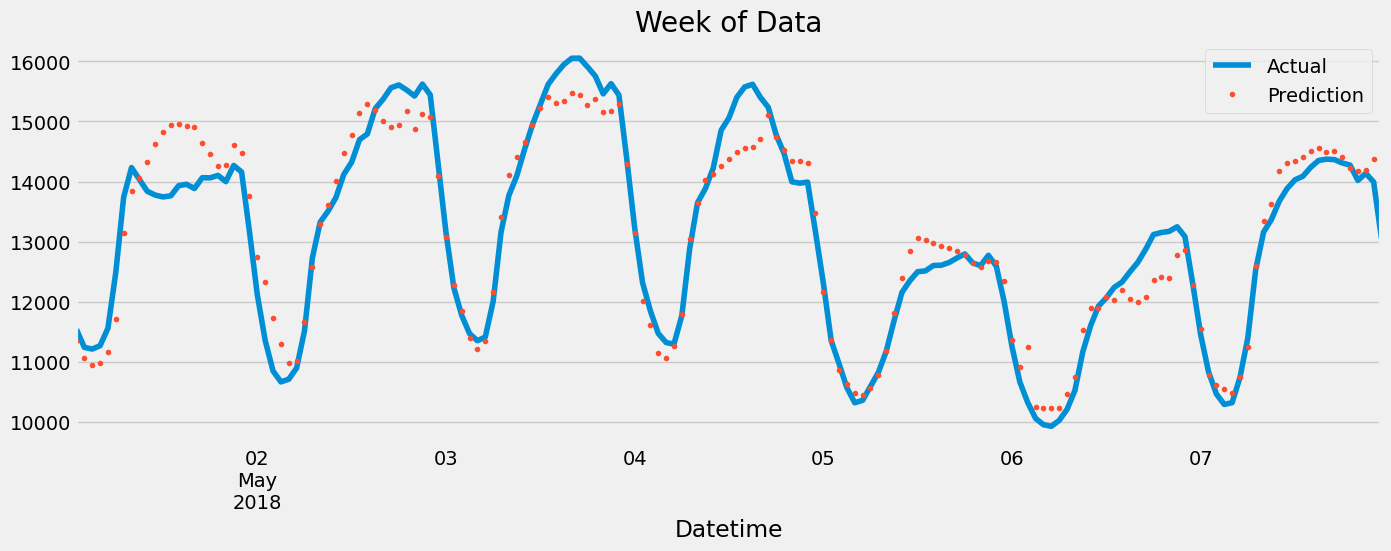

In [45]:
ax = df_copy.loc[(df_copy.index > '2018-05-01') & (df_copy.index < '2018-05-08')][['aep_mw']].plot(
    figsize=(15, 5), title='Week of Data')
df_copy.loc[(df_copy.index > '2018-05-01') & (df_copy.index < '2018-05-08')][['prediction']].plot(ax=ax, style='.')
plt.legend(['Actual', 'Prediction'])
plt.show()


In [46]:
rsme = root_mean_squared_error(test['aep_mw'], test['prediction'])
print(f'RMSE: {rsme:.2f}')

RMSE: 633.72


In [47]:
mae = mean_absolute_error(test['aep_mw'], test['prediction'])
print(f'MAE: {mae:.2f}')

MAE: 447.46


In [48]:
epsilon = 1e-10  # small number to avoid division by zero
mape = np.mean(np.abs((test['aep_mw'] - test['prediction']) / (test['aep_mw'] + epsilon))) * 100
print(f'MAPE: {mape:.2f}%')

MAPE: 3.00%


In [49]:
mdape = np.median(np.abs((test['aep_mw'] - test['prediction']) / test['aep_mw'])) * 100
print(f'MdAPE: {mdape:.2f}%')


MdAPE: 2.23%


## Calculate Error

In [50]:
test['error'] = np.abs(test[target] - test['prediction'])
test['date'] = test.index.date

In [51]:
test.groupby('date')['error'].mean().sort_values(ascending=False).round(2).head(10)

date
2017-12-31    3173.18
2017-02-10    2331.29
2016-12-16    2131.75
2015-02-06    2054.54
2015-03-07    1879.74
2016-11-23    1718.64
2018-01-19    1717.80
2015-03-06    1667.71
2018-01-07    1600.23
2016-01-13    1574.58
Name: error, dtype: float64

In [52]:
test.groupby('date')['error'].mean().sort_values(ascending=True).round(2).head(10)

date
2015-10-13    113.29
2015-10-10    115.59
2016-08-04    115.75
2015-04-08    118.73
2015-10-24    120.67
2015-09-21    121.70
2017-05-06    122.87
2017-04-24    122.93
2017-09-13    123.05
2017-06-16    127.85
Name: error, dtype: float64

In [53]:
test.head()

,aep_mw,hour,dayofweek,month,is_weekend,is_holiday,is_new_year_eve,lag_24,rolling_mean_24,rolling_std_24,...,hour_is_holiday,hour_is_weekend,is_night,is_morning,is_noon,is_evening,is_outlier,prediction,error,date
Datetime,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,13487.0,0,4,1,0,1,0,16375.0,14061.541667,1231.653430,...,0,0,1,0,0,0,0,13400.622070,86.377930,2016-01-01
2015-12-30 01:00:00,12665.0,1,2,12,0,0,0,12415.0,13941.208333,1132.922346,...,0,0,1,0,0,0,0,13349.090820,684.090820,2015-12-30
2015-12-30 02:00:00,12291.0,2,2,12,0,0,0,12087.0,13951.625000,1119.347473,...,0,0,1,0,0,0,0,13281.630859,990.630859,2015-12-30
2015-12-30 03:00:00,12252.0,3,2,12,0,0,0,12010.0,13960.125000,1105.258314,...,0,0,1,0,0,0,0,13245.686523,993.686523,2015-12-30
2015-12-30 04:00:00,12128.0,4,2,12,0,0,0,11972.0,13970.208333,1087.657434,...,0,0,1,0,0,0,0,13169.043945,1041.043945,2015-12-30


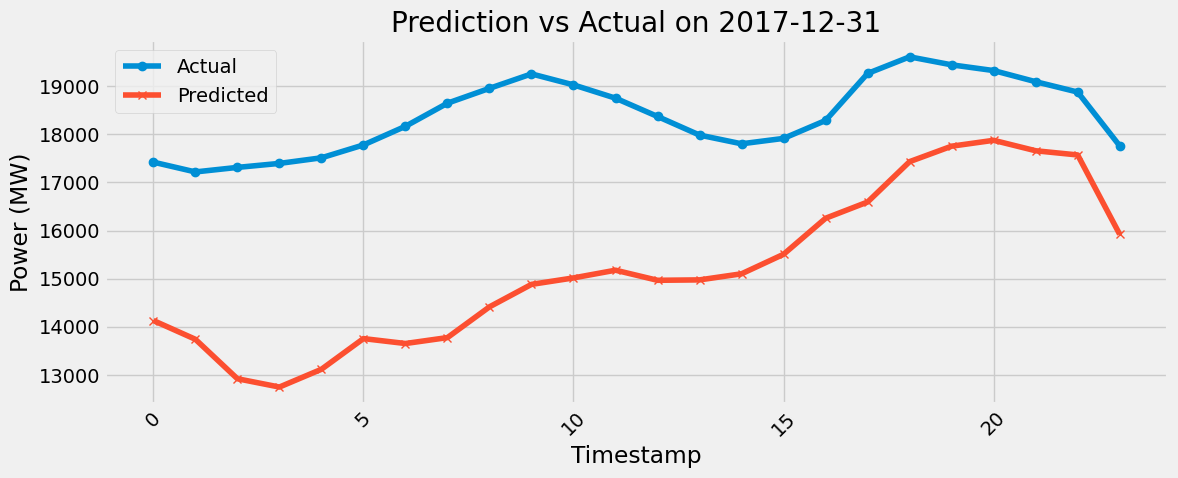

In [54]:
# Ensure 'date' column is datetime (probably already is)
test['date'] = pd.to_datetime(test['date'])

# Convert string to datetime for comparison
worst_day = pd.to_datetime('2017-12-31')

# Filter rows from that day using the 'date' column
subset = test[test['date'] == worst_day]

# Optional: Reset index if needed for plotting
subset = subset.reset_index()  # Bring datetime back as a column

# Check if data exists
if not subset.empty:
    plt.figure(figsize=(12, 5))
    plt.plot(subset['aep_mw'], label='Actual', marker='o')
    plt.plot(subset['prediction'], label='Predicted', marker='x')
    plt.title(f"Prediction vs Actual on {worst_day.date()}")
    plt.xlabel("Timestamp")
    plt.ylabel("Power (MW)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print(f"No data available for {worst_day.date()}")


In [55]:

# Extract day and month
test['day'] = test['date'].dt.day
test['month'] = test['date'].dt.month

# Filter for December 31 and January 1
ny_eve = test[(test['day'] == 31) & (test['month'] == 12)]
ny_day = test[(test['day'] == 1) & (test['month'] == 1)]


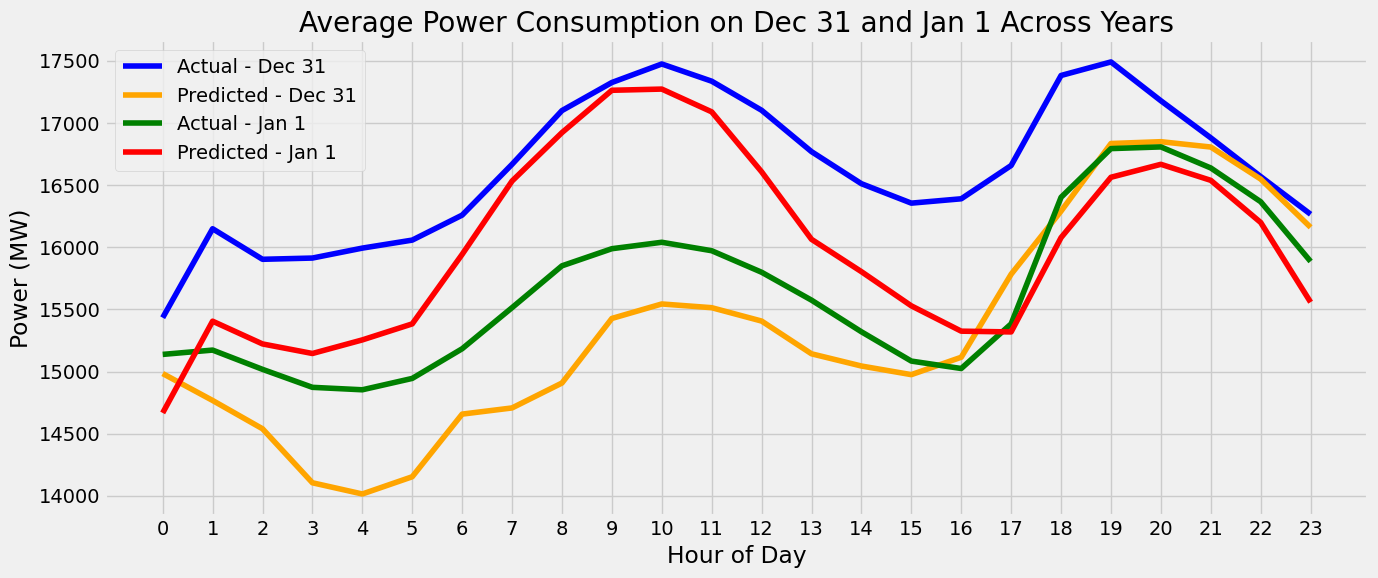

In [56]:
# Average across all years for each hour
ny_eve_grouped = ny_eve.groupby('hour')[['aep_mw', 'prediction']].mean()
ny_day_grouped = ny_day.groupby('hour')[['aep_mw', 'prediction']].mean()

# Plot
plt.figure(figsize=(14, 6))

plt.plot(ny_eve_grouped.index, ny_eve_grouped['aep_mw'], label='Actual - Dec 31', color='blue')
plt.plot(ny_eve_grouped.index, ny_eve_grouped['prediction'], label='Predicted - Dec 31', color='orange')

plt.plot(ny_day_grouped.index, ny_day_grouped['aep_mw'], label='Actual - Jan 1', color='green')
plt.plot(ny_day_grouped.index, ny_day_grouped['prediction'], label='Predicted - Jan 1', color='red')

plt.title('Average Power Consumption on Dec 31 and Jan 1 Across Years')
plt.xlabel('Hour of Day')
plt.ylabel('Power (MW)')
plt.grid(True)
plt.legend()
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

## Next Steps
- More robust cross validation
- Add more features (weather forecast, holidays)